In [10]:
##### GCN Model ######
import pickle as pkl
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.sparse as sp
import math
import os
import numpy.linalg as la
import matplotlib.pyplot as plt
#from tgcn import tgcnCell
#from gru import GRUCell
from sklearn.metrics import mean_squared_error,mean_absolute_error
import time
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [11]:
def normalized_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    normalized_adj = normalized_adj.astype(np.float32)
    return normalized_adj

def sparse_to_tuple(mx):
    mx = mx.tocoo()
    coords = np.vstack((mx.row, mx.col)).transpose()
    L = tf.SparseTensor(coords, mx.data, mx.shape)
    return tf.sparse.reorder(L)

def calculate_laplacian(adj, lambda_max=1):
    adj = normalized_adj(adj + sp.eye(adj.shape[0]))
    adj = sp.csr_matrix(adj)
    adj = adj.astype(np.float32)
    return sparse_to_tuple(adj)

def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random.uniform([input_dim, output_dim], minval=-init_range,
                            maxval=init_range, dtype=tf.float32)

    return tf.Variable(initial,name=name)


def preprocess_data(data, time_len, rate, seq_len, pre_len):
    train_size = int(time_len * rate)
    train_data = data[0:train_size]
    test_data = data[train_size:time_len]

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])

    trainX1 = np.array(trainX)
    trainY1 = np.array(trainY)
    testX1 = np.array(testX)
    testY1 = np.array(testY)
    return trainX1, trainY1, testX1, testY1

In [12]:
from tensorflow.compat.v1.nn.rnn_cell import RNNCell
from tensorflow.python.platform import tf_logging as logging


class GRUCell(RNNCell):
    """Gated Recurrent Units. """
    
    def call(self, inputs, **kwargs):
        pass

    def __init__(self, num_units, num_nodes, input_size=None,
                 act=tf.nn.tanh, reuse=None):
        """Gated Recurrent Units."""
        
        super(GRUCell, self).__init__(_reuse=reuse)
        if input_size is not None:
            logging.warn("%s: The input_size parameter is deprecated.", self)
        self._act = act
        self._num_nodes = num_nodes
        self._num_units = num_units



    @property
    def state_size(self):
        return self._num_nodes * self._num_units

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):

        with tf.variable_scope(scope or "gru"):
            with tf.variable_scope("gates"): 
                # Reset gate and update gate.
                value = tf.nn.sigmoid(
                    self._linear(inputs, state, 2 * self._num_units, bias=1.0, scope=scope))
                r, u = tf.split(value=value, num_or_size_splits=2, axis=1)
            with tf.variable_scope("candidate"):
                c = self._linear(inputs, r * state, self._num_units, scope=scope)
#                c = self._linear(inputs, r * state, scope=scope)
                if self._act is not None:
                    c = self._act(c)
            new_h = u * state + (1 - u) * c
        return new_h, new_h
        
    
    def _linear(self, inputs, state, output_size, bias=0.0, scope=None):
        ## inputs:(-1,num_nodes)
#        print('1',inputs.get_shape())
        inputs = tf.expand_dims(inputs, 2)
#        print('2',inputs.get_shape())
       
        ## state:(batch,num_node,gru_units)
#        print('2',state.get_shape())
        state = tf.reshape(state, (-1, self._num_nodes, self._num_units))
#        print('2',state.get_shape())
        
        x_h  = tf.concat([inputs, state], axis=2)
        input_size = x_h.get_shape()[2].value
        
        x = tf.reshape(x_h, shape=[-1, input_size])

        scope = tf.get_variable_scope()
        with tf.variable_scope(scope):
            weights = tf.get_variable(
                'weights', [input_size, output_size], initializer=tf.contrib.layers.xavier_initializer())
            biases = tf.get_variable(
                "biases", [output_size], initializer=tf.constant_initializer(bias))

            x = tf.matmul(x, weights)  # (batch_size * self.num_nodes, output_size)          
            x = tf.nn.bias_add(x, biases)

            x = tf.reshape(x, shape=[-1, self._num_nodes ,output_size])
            x = tf.reshape(x, shape=[-1, self._num_nodes * output_size])
        return x  

In [13]:
from tensorflow.compat.v1.nn.rnn_cell import RNNCell

class tgcnCell(RNNCell):
    """Temporal Graph Convolutional Network """

    def call(self, inputs, **kwargs):
        pass

    def __init__(self, num_units, adj, num_nodes, input_size=None,
                 act=tf.nn.tanh, reuse=None):

        super(tgcnCell, self).__init__(_reuse=reuse)
        self._act = act
        self._nodes = num_nodes
        self._units = num_units
        self._adj = []
        self._adj.append(calculate_laplacian(adj))


    @property
    def state_size(self):
        return self._nodes * self._units

    @property
    def output_size(self):
        return self._units

    def __call__(self, inputs, state, scope=None):

        with tf.compat.v1.variable_scope(scope or "tgcn"):
            with tf.compat.v1.variable_scope("gates"):
                value = tf.nn.sigmoid(
                    self._gc(inputs, state, 2 * self._units, bias=1.0, scope=scope))
                r, u = tf.split(value=value, num_or_size_splits=2, axis=1)
            with tf.compat.v1.variable_scope("candidate"):
                r_state = r * state
                c = self._act(self._gc(inputs, r_state, self._units, scope=scope))
            new_h = u * state + (1 - u) * c
        return new_h, new_h


    def _gc(self, inputs, state, output_size, bias=0.0, scope=None):
        ## inputs:(-1,num_nodes)
        inputs = tf.expand_dims(inputs, 2)
        ## state:(batch,num_node,gru_units)
        state = tf.reshape(state, (-1, self._nodes, self._units))
        ## concat
        x_s = tf.concat([inputs, state], axis=2)
        input_size = x_s.get_shape()[2]#.value
        ## (num_node,input_size,-1)
        x0 = tf.transpose(a=x_s, perm=[1, 2, 0])
        x0 = tf.reshape(x0, shape=[self._nodes, -1])

        scope = tf.compat.v1.get_variable_scope()
        with tf.compat.v1.variable_scope(scope):
            for m in self._adj:
                x1 = tf.sparse.sparse_dense_matmul(m, x0)
#                print(x1)
            x = tf.reshape(x1, shape=[self._nodes, input_size,-1])
            x = tf.transpose(a=x,perm=[2,0,1])
            x = tf.reshape(x, shape=[-1, input_size])
            weights = tf.compat.v1.get_variable(
                'weights', [input_size, output_size], initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
            x = tf.matmul(x, weights)  # (batch_size * self._nodes, output_size)
            biases = tf.compat.v1.get_variable(
                "biases", [output_size], initializer=tf.compat.v1.constant_initializer(bias, dtype=tf.float32))
            x = tf.nn.bias_add(x, biases)
            x = tf.reshape(x, shape=[-1, self._nodes, output_size])
            x = tf.reshape(x, shape=[-1, self._nodes * output_size])
        return x

In [14]:
def plot_result(test_result,test_label1,path):
    ##all test result visualization
    fig1 = plt.figure(figsize=(7,1.5))
#    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_result[:,0]
    a_true = test_label1[:,0]
    plt.plot(a_pred,'r-',label='prediction')
    plt.plot(a_true,'b-',label='true')
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_all.jpg')
    plt.show()
    ## oneday test result visualization
    fig1 = plt.figure(figsize=(7,1.5))
#    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_result[0:96,0]
    a_true = test_label1[0:96,0]
    plt.plot(a_pred,'r-',label="prediction")
    plt.plot(a_true,'b-',label="true")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_oneday.jpg')
    plt.show()

def plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path):
    ###train_rmse & test_rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_rmse, 'r-', label="train_rmse")
    plt.plot(test_rmse, 'b-', label="test_rmse")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/rmse.jpg')
    plt.show()
    #### train_loss & train_rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_loss,'b-', label='train_loss')
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/train_loss.jpg')
    plt.show()

    fig1 = plt.figure(figsize=(5,3))
    plt.plot(train_rmse,'b-', label='train_rmse')
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/train_rmse.jpg')
    plt.show()

    ### accuracy
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_acc, 'b-', label="test_acc")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_acc.jpg')
    plt.show()
    ### rmse
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_rmse, 'b-', label="test_rmse")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_rmse.jpg')
    plt.show()
    ### mae
    fig1 = plt.figure(figsize=(5,3))
    plt.plot(test_mae, 'b-', label="test_mae")
    plt.legend(loc='best',fontsize=10)
    plt.savefig(path+'/test_mae.jpg')
    plt.show()


In [15]:
###### Settings ######

data = pd.read_csv('ModData.csv',header=None)    #load data
adj = np.mat(pd.read_csv('ModAdj2.csv',header=None)) #load adjacency matrix


time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32) 

## Initialization parameters
seq_len = 12
pre_len = 5
learning_rate =  0.001
training_epoch = 250
gru_units =  64
train_rate = 0.8
batch_size = 32
model_name = 'tgcn'
data_name = 'theta'

#### normalization
max_value = np.max(data1)
data1  = data1/max_value
trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len)

totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)



In [16]:
##### Model definition #####
def TGCN(_X, _weights, _biases):
    ###
    cell_1 = tgcnCell(gru_units, adj, num_nodes=num_nodes)
    cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.compat.v1.nn.static_rnn(cell, _X, dtype=tf.float32)
    m = []
    for i in outputs:
        o = tf.reshape(i,shape=[-1,num_nodes,gru_units])
        o = tf.reshape(o,shape=[-1,gru_units])
        m.append(o)
    last_output = m[-1]
    output = tf.matmul(last_output, _weights['out']) + _biases['out']
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len])
    output = tf.transpose(a=output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])
    return output, m, states
        

In [17]:
###### placeholders ######
tf.compat.v1.disable_eager_execution()
inputs = tf.compat.v1.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.compat.v1.placeholder(tf.float32, shape=[None, pre_len, num_nodes])

# Graph weights
weights = {
    'out': tf.Variable(tf.random.normal([gru_units, pre_len], mean=1.0), name='weight_o')}
biases = {
    'out': tf.Variable(tf.random.normal([pre_len]),name='bias_o')}

#if model_name == 'tgcn':
pred,ttts,ttto = TGCN(inputs, weights, biases)
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

#pred,ttts,ttto = GRU(inputs, weights, biases)

y_pred = pred


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
###### optimizer ######
lambda_loss = 0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])
##loss
loss = tf.reduce_mean(input_tensor=tf.nn.l2_loss(y_pred-label) + Lreg)
##rmse
error = tf.sqrt(tf.reduce_mean(input_tensor=tf.square(y_pred-label)))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)



In [19]:
###### Initialize session ######
variables = tf.compat.v1.global_variables()
saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())
#sess = tf.Session()
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
sess.run(tf.compat.v1.global_variables_initializer())

out = 'out/%s'%(model_name)
#out = 'out/%s_%s'%(model_name,'perturbation')
path1 = '%s_%s_lr%r_batch%r_unit%r_seq%r_pre%r_epoch%r'%(model_name,data_name,learning_rate,batch_size,gru_units,seq_len,pre_len,training_epoch)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)


In [20]:
###### evaluation ######
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return rmse, mae, 1-F_norm, r2, var


x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]


In [21]:
##### Trainning Loop #####
time_start = time.time()

for epoch in range(training_epoch):
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output = sess.run([optimizer, loss, error, y_pred],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        batch_loss.append(loss1)
        batch_rmse.append(rmse1 * max_value)

     # Test completely at every epoch
    loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:testX, labels:testY})
    test_label = np.reshape(testY,[-1,num_nodes])
    rmse, mae, acc, r2_score, var_score = evaluation(test_label, test_output)
    test_label1 = test_label * max_value
    test_output1 = test_output * max_value
    test_loss.append(loss2)
    test_rmse.append(rmse * max_value)
    test_mae.append(mae * max_value)
    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)

    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_acc:{:.4}'.format(acc))

    if (epoch % 500 == 0):
        saver.save(sess, path+'/model_100/TGCN_pre_%r'%epoch, global_step = epoch)

time_end = time.time()
print(time_end-time_start,'s')


Iter:0 train_rmse:8.743 test_loss:7.194e+03 test_rmse:0.2054 test_acc:0.6117
Iter:1 train_rmse:5.596 test_loss:2.991e+03 test_rmse:0.1324 test_acc:0.7496
Iter:2 train_rmse:3.685 test_loss:1.33e+03 test_rmse:0.08829 test_acc:0.8331
Iter:3 train_rmse:2.929 test_loss:844.6 test_rmse:0.07035 test_acc:0.867
Iter:4 train_rmse:2.566 test_loss:646.4 test_rmse:0.06154 test_acc:0.8837
Iter:5 train_rmse:2.307 test_loss:519.6 test_rmse:0.05517 test_acc:0.8957
Iter:6 train_rmse:2.111 test_loss:433.5 test_rmse:0.05039 test_acc:0.9047
Iter:7 train_rmse:1.971 test_loss:376.8 test_rmse:0.04697 test_acc:0.9112
Iter:8 train_rmse:1.875 test_loss:340.1 test_rmse:0.04462 test_acc:0.9156
Iter:9 train_rmse:1.808 test_loss:316.0 test_rmse:0.04301 test_acc:0.9187
Iter:10 train_rmse:1.761 test_loss:299.5 test_rmse:0.04187 test_acc:0.9208
Iter:11 train_rmse:1.724 test_loss:287.3 test_rmse:0.041 test_acc:0.9225
Iter:12 train_rmse:1.694 test_loss:277.4 test_rmse:0.04028 test_acc:0.9238
Iter:13 train_rmse:1.668 test

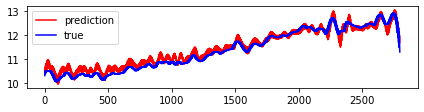

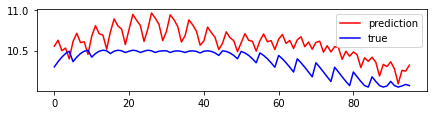

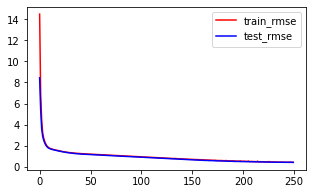

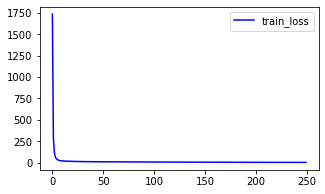

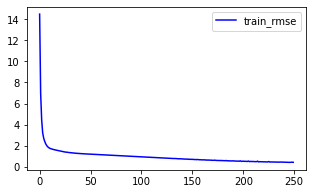

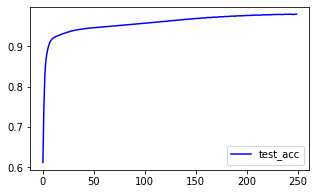

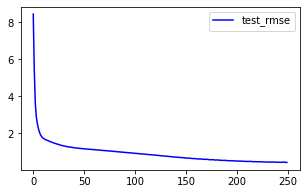

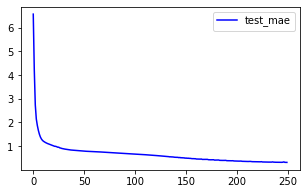

min_rmse:0.424238662549024 min_mae:0.31453836 max_acc:0.9804838337004185 r2:0.9966463930904865 var:0.9966654488816857


In [22]:
############## visualization ###############
b = int(len(batch_rmse)/totalbatch)
batch_rmse1 = [i for i in batch_rmse]
train_rmse = [(sum(batch_rmse1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
batch_loss1 = [i for i in batch_loss]
train_loss = [(sum(batch_loss1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]

index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
var = pd.DataFrame(test_result)
var.to_csv(path+'/test_result.csv',index = False,header = False)
plot_result(test_result,test_label1,path)
plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)

print('min_rmse:%r'%(np.min(test_rmse)),
      'min_mae:%r'%(test_mae[index]),
      'max_acc:%r'%(test_acc[index]),
      'r2:%r'%(test_r2[index]),
      'var:%r'%test_var[index])

In [23]:
test_label1[:,1], test_output1.shape, len(test_rmse)

(array([10.810405, 10.87405 , 10.929953, ..., 12.201979, 12.000003,
        11.81154 ], dtype=float32),
 (2795, 122),
 250)

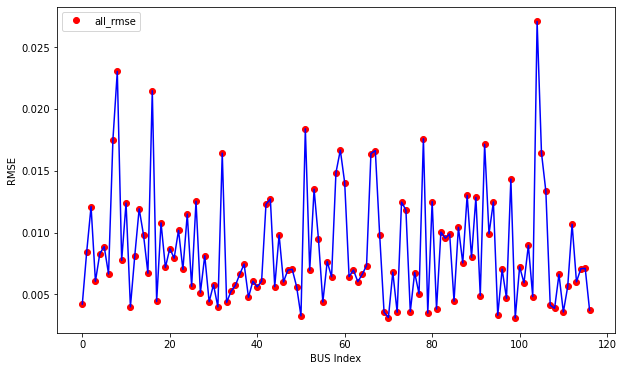

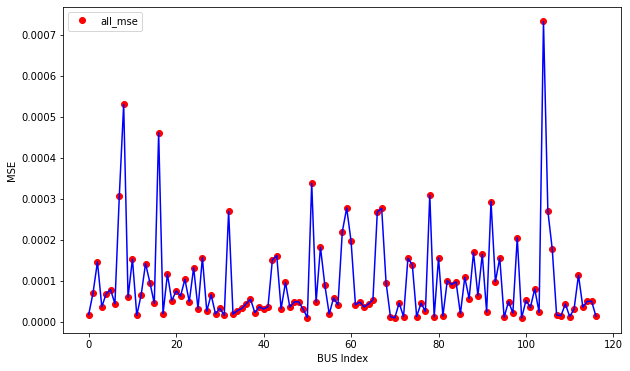

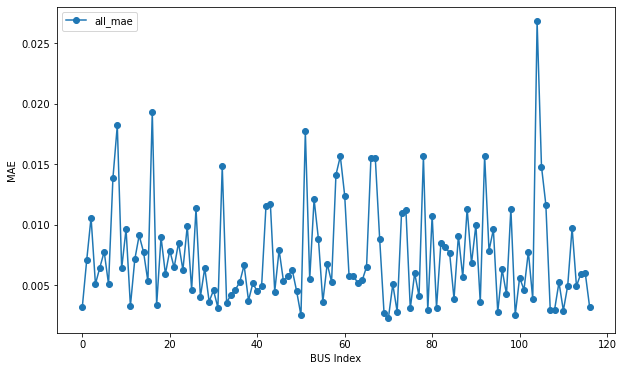

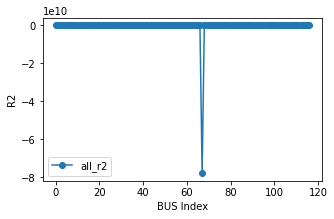

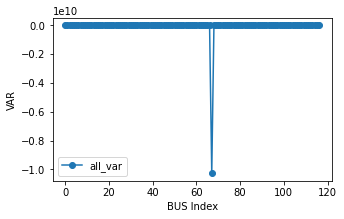

In [24]:
all_mse, all_rmse, all_mae, all_r2, all_var = [], [], [], [], []
for i in range(1,118):
    a,b = test_label[:,i], test_output[:,i] 
    mse1 = mean_squared_error(a,b)
    rmse1 = math.sqrt(mean_squared_error(a,b))
    mae1 = mean_absolute_error(a, b)
    #F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r21 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var1 = 1-(np.var(a-b))/np.var(a)
    all_mse.append(mse1)
    all_rmse.append(rmse1)
    all_mae.append(mae1)
    all_r2.append(r21)
    all_var.append(var1)

### All_rmse
fig1 = plt.figure(figsize=(10,6))
plt.plot(all_rmse, 'ro', label="all_rmse")
plt.plot(all_rmse, 'b-')
plt.legend(loc='best',fontsize=10)
plt.xlabel('BUS Index')
plt.ylabel('RMSE')
plt.savefig('all_rmse.png')
plt.show()

fig5 = plt.figure(figsize=(10,6))
plt.plot(all_mse, 'ro', label="all_mse")
plt.plot(all_mse, 'b-')
plt.legend(loc='best',fontsize=10)
plt.xlabel('BUS Index')
plt.ylabel('MSE')
plt.savefig('all_mse.png')
plt.show()

fig2 = plt.figure(figsize=(10,6))
plt.plot(all_mae, '-o', label="all_mae")
plt.legend(loc='best',fontsize=10)
plt.xlabel('BUS Index')
plt.ylabel('MAE')
plt.savefig('all_mae.png')
plt.show()

fig3 = plt.figure(figsize=(5,3))
plt.plot(all_r2, '-o', label="all_r2")
plt.legend(loc='best',fontsize=10)
plt.xlabel('BUS Index')
plt.ylabel('R2')
plt.savefig('all_r2.png')
plt.show()

fig4 = plt.figure(figsize=(5,3))
plt.plot(all_var, '-o', label="all_var")
plt.legend(loc='best',fontsize=10)
plt.xlabel('BUS Index')
plt.ylabel('VAR')
plt.savefig('all_var.png')
plt.show()

